Input images for this are from the diffIm_demo DECAM data that Yusra gave me. 
First, I ran `imageDifference.py` with `doDecorrelation = False`. Then copied the diffim to the current directory:
```
cp decamDirTest/deepDiff/v289820/diffexp-11.fits .
```
Then I ran it with `doDecorrelation = True`, so the decorrelated diffim now lies in:
```
decamDirTest/deepDiff/v289820/diffexp-11.fits
```

Without the correction, at 5.5 sigma, 58,98 positive,negative sources were detected (143 merged). 
At 5.0 sigma, it is 89,328 (395 merged).

With the correction (at 5.5-sigma) it is only 35,15 (41 merged).
At 5.0 sigma on the decorrelated image we get 43,18 detections (50 merged).

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import scipy.stats

#  LSST imports:
import lsst.afw.image as afwImage
from lsst.afw.table import (SourceTable, SourceCatalog)
from lsst.meas.base import SingleFrameMeasurementConfig
from lsst.meas.algorithms import (SourceDetectionConfig, SourceDetectionTask)

import diffimTests as dit
import lsst.ip.diffim.imageDecorrelation as id

reload(dit)
reload(id);

In [191]:
im1 = afwImage.ExposureF('diffexp-11.fits')   # uncorrected diffim
im2 = afwImage.ExposureF('decamDirTest/deepDiff/v289820/diffexp-11.fits')  # decorrelated diffim

# Also load the original science and template images
sciImg = afwImage.ExposureF('calexpDir_b1631/0289820/calexp/calexp-0289820_11.fits')
templImg = afwImage.ExposureF('calexpDir_b1631/0288976/calexp/calexp-0288976_11.fits')

In [126]:
print 'Stats of variance planes:'
print dit.computeClippedAfwStats(sciImg.getMaskedImage().getVariance(),
                                maskIm=sciImg.getMaskedImage().getMask())  # mean, std, var
print dit.computeClippedAfwStats(templImg.getMaskedImage().getVariance(),
                                maskIm=templImg.getMaskedImage().getMask())
print dit.computeClippedAfwStats(im1.getMaskedImage().getVariance(),
                                maskIm=im1.getMaskedImage().getMask())
print dit.computeClippedAfwStats(im2.getMaskedImage().getVariance(),
                                maskIm=im2.getMaskedImage().getMask())

print '\nStats of image pixels:'
print dit.computeClippedAfwStats(sciImg.getMaskedImage())
print dit.computeClippedAfwStats(templImg.getMaskedImage())
print dit.computeClippedAfwStats(im1.getMaskedImage())
print dit.computeClippedAfwStats(im2.getMaskedImage())

Stats of variance planes:
(62.77782901700841, 2.5060648726354002, 6.280361145857084)
(59.99452575747201, 2.4514634731193685, 6.009673160038477)
(66.87903634374102, 2.5179893368341237, 6.340270300410351)
(120.81102171364827, 4.51612434810661, 20.395379127561352)

Stats of image pixels:
(0.0005585483212044934, 8.311411313575924, 69.07955802343785)
(0.0004579826852987869, 8.164932806235559, 66.66612773034169)
(-0.4661162311167405, 8.61241098523501, 74.17362297859668)
(-0.46592722419628463, 11.485577216177695, 131.91848398878017)


UNCORRECTED: (-0.4661162311167405, 8.61241098523501, 74.17362297859668)
CORRECTED:   (-0.46592722419628463, 11.485577216177695, 131.91848398878017)
8090901 7945108


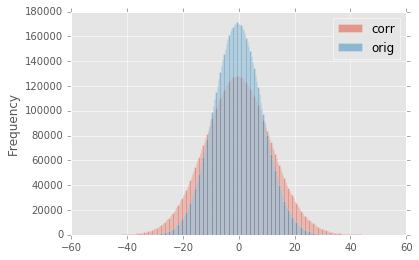

In [4]:
def getClippedPixels(pixels):
    pix = pixels[~(np.isnan(pixels)|np.isinf(pixels))]
    pix = pix[pix != 0.]
    pix, _, _ = scipy.stats.sigmaclip(pix)
    return pix

im1a = getClippedPixels(im1.getMaskedImage().getImage().getArray())
im2a = getClippedPixels(im2.getMaskedImage().getImage().getArray())
print len(im1a), len(im2a)
im1a = im1a[:len(im2a)]

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a})
df.plot.hist(alpha=0.5, bins=200)

0.348901792193
0.0600425152596


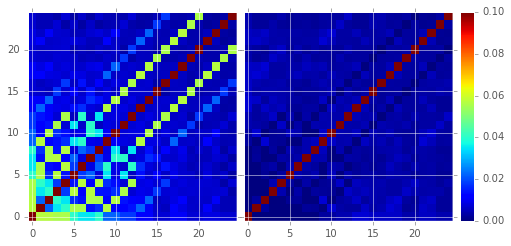

In [50]:
def computePixelCovariances(im):
    im1a = im.getMaskedImage().getImage().getArray()
    im1a[np.isnan(im1a)|np.isinf(im1a)] = 0.
    _, low, upp = scipy.stats.sigmaclip(im1a)
    im1a[(im1a < low)|(im1a > upp)] = 0.
    cov1, ratioOffDiag = dit.computePixelCovariance(im1a)
    return cov1, ratioOffDiag

cov1, ratioOffDiag = computePixelCovariances(im1)
print ratioOffDiag
cov2, ratioOffDiag = computePixelCovariances(im2)
print ratioOffDiag
dit.plotImageGrid((cov1, cov2), imScale=4., clim=(0, 0.1), cmap=None)

True
1.99417145453 2.15338379076
1.00014561851 1.0
(14, 14) (14, 15)


DescribeResult(nobs=841, minmax=(-0.0039582455147291161, 0.0063042582701758575), mean=1.7314923479202881e-07, variance=4.5185482781990201e-07, skewness=3.137660766003021, kurtosis=35.56281290854448)

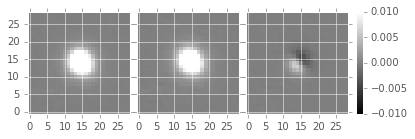

In [6]:
print im2.hasPsf()
im1_psf = im1.getPsf().computeImage().getArray()
im2_psf = im2.getPsf().computeImage().getArray()
print im1.getPsf().computeShape().getDeterminantRadius(), im2.getPsf().computeShape().getDeterminantRadius()
print im1_psf.sum(), im2_psf.sum()
print np.unravel_index(im1_psf.argmax(), im1_psf.shape), np.unravel_index(im2_psf.argmax(), im2_psf.shape)
dit.plotImageGrid((im1.getPsf().computeImage().getArray(), im2_psf, 
                   im1.getPsf().computeImage().getArray() - im2_psf), imScale=2., clim=(-0.01,0.01))
scipy.stats.describe(im1.getPsf().computeImage().getArray() - im2_psf, None)

Here we note that the variance plane appears to be getting set a bit too low in the corrected diffim...?
(121 vs. expected 123...?)

The variance in the "expected" array might be a bit too high because I am subtracting the science image minus the *original* unwarped template, thus it has lots of positive and negative sources in it. How can I get at the warped (but not convolved) template? Actually that may not help as the subtraction will still have substantial positive- and negative residuals.

SCIENCE: (62.77782901700841, 2.5060648726354002, 6.280361145857084)
TEMPLATE:   (59.99452575747201, 2.4514634731193685, 6.009673160038477)
UNCORRECTED: (66.87903634374102, 2.5179893368341237, 6.340270300410351)
CORRECTED:   (120.81102171364827, 4.51612434810661, 20.395379127561352)
EXPECTED:    (122.99760789879473, 3.684410099348342, 13.574877780180062)
7520808 7243484 8087169 8089345


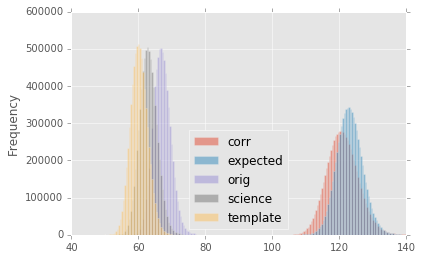

In [7]:
im1a = im1.getMaskedImage().getVariance()
im2a = im2.getMaskedImage().getVariance()
imsa = sciImg.getMaskedImage().getVariance()
imta = templImg.getMaskedImage().getVariance()

tmp = sciImg.getMaskedImage().clone()
tmp -= templImg.getMaskedImage()
tmp = tmp.getVariance()

print 'SCIENCE:', dit.computeClippedAfwStats(imsa, maskIm=sciImg.getMaskedImage().getMask())
print 'TEMPLATE:  ', dit.computeClippedAfwStats(imta, maskIm=templImg.getMaskedImage().getMask())
print 'UNCORRECTED:', dit.computeClippedAfwStats(im1a, maskIm=im1.getMaskedImage().getMask())
print 'CORRECTED:  ', dit.computeClippedAfwStats(im2a, maskIm=im2.getMaskedImage().getMask())
tmp = imsa.clone(); tmp += imta
print 'EXPECTED:   ', dit.computeClippedAfwStats(tmp, maskIm=im1.getMaskedImage().getMask())

def getClippedPixels(pixels):
    pix = pixels[~(np.isnan(pixels)|np.isinf(pixels))]
    pix = pix[pix != 0.]
    pix, _, _ = scipy.stats.sigmaclip(pix)
    return pix

im1a = getClippedPixels(im1a.getArray())
im2a = getClippedPixels(im2a.getArray())
imsa = getClippedPixels(imsa.getArray())
imta = getClippedPixels(imta.getArray())
tmp = getClippedPixels(tmp.getArray())
print len(im1a), len(im2a), len(imsa), len(imta)
im1a = im1a[:len(im2a)]
imsa = imsa[:len(im2a)]
imta = imta[:len(im2a)]
tmp = tmp[:len(im2a)]
expected = tmp

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a, 'science': imsa, 'template': imta, 'expected': expected})
df.plot.hist(alpha=0.5, bins=200)

Try again, using updated `DecorrelateALKernelTask.run()` that can take input variances and coordinate to use to compute the matching kernel to use to compute the decorrelation kernel.

See how the variance plane statistics are varying across the images...

Compute statistics across 100x100-pixel boxes on the image. 

70.0 0.496947467017
133.91465396 0.983996259281
64.12224528 0.45814728892
61.5340751045 0.453035093481


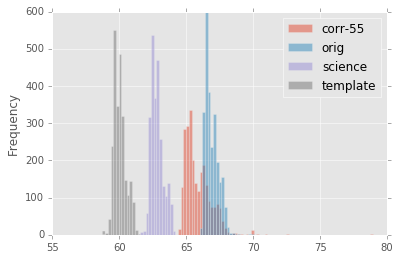

In [8]:
import lsst.afw.geom as afwGeom

def computeVarianceBoxStats(im, doPixelsInstead=False):
    im1a = im.getMaskedImage().getVariance()
    if doPixelsInstead:
        im1a = im.getMaskedImage().getImage()
    im1m = im.getMaskedImage().getMask()
    box = im1a.getBBox()
    sz = im1a.getArray().shape
    boxSize = afwGeom.ExtentI(100, 100)
    boxes = [afwGeom.Box2I(afwGeom.PointI(x, y), boxSize) for y in np.linspace(0, sz[0]-101, 50, dtype=int) \
             for x in np.linspace(0, sz[1]-101, 50, dtype=int)]
    subims = [[afwImage.ImageF(im1a, box, afwImage.PARENT), afwImage.MaskU(im1m, box, afwImage.PARENT)] for box in boxes]
    return [dit.computeClippedAfwStats(sub[0], maskIm=sub[1]) for sub in subims]

# Plot means in variance planes...
tmp = computeVarianceBoxStats(im1)
im1stats = np.array([t[0] for t in tmp]); im1stats[im1stats>70] = 70; print im1stats.max(), im1stats.std()
tmp = computeVarianceBoxStats(im2)
im2stats = np.array([t[0] for t in tmp]); im2stats[im2stats>135] = 125; print im2stats.max(), im2stats.std()
tmp = computeVarianceBoxStats(sciImg)
scistats = np.array([t[0] for t in tmp]); print scistats.max(), scistats.std()
tmp = computeVarianceBoxStats(templImg)
templstats = np.array([t[0] for t in tmp]); print templstats.max(), templstats.std()

df = pd.DataFrame({'corr-55': im2stats-55., 'orig': im1stats, 'science': scistats, 'template': templstats})
#df = pd.DataFrame({'orig': im1stats, 'science': scistats, 'template': templstats})
df.plot.hist(alpha=0.5, bins=100)

OK, then let's look at the matching kernel variation across the image.

Ran imageDecorrelation with this code added to dump the spatialKernel (it can be pickled!):

```
cPickle.dump(spatialKernel, gzip.GzipFile('spatialKernel.p.gz', 'wb'))
```

In [9]:
import cPickle
import gzip
im1a = im1.getMaskedImage().getVariance()
bbox = im1a.getBBox()
spatialKernel = cPickle.load(gzip.GzipFile('spatialKernel.p.gz', 'rb'))

def getSpatialKernelImage(spatialKernel, xcen, ycen):
    kimg = afwImage.ImageD(spatialKernel.getDimensions())
    spatialKernel.computeImage(kimg, True, xcen, ycen)
    return kimg.getArray()

kimages = [getSpatialKernelImage(spatialKernel, xc, yc) for
           xc in np.linspace(bbox.getBeginX(), bbox.getEndX(), 10.) for
           yc in np.linspace(bbox.getBeginY(), bbox.getEndY(), 10.)]
print "HERE:", len(kimages)

HERE: 100


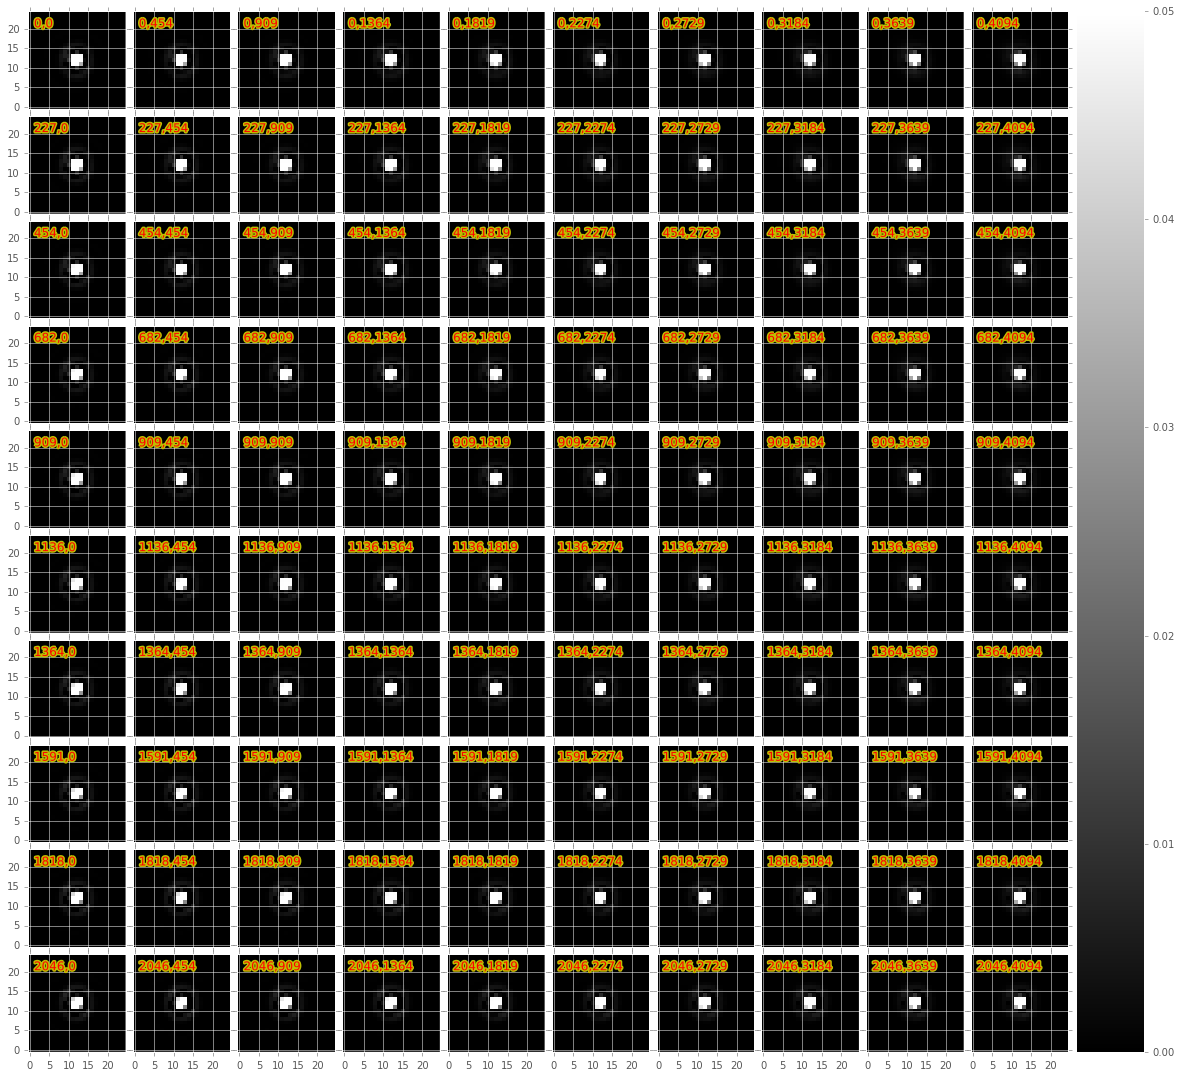

In [10]:
titles = ['%d,%d' % (x,y) for \
          x in np.linspace(bbox.getBeginX(), bbox.getEndX(), 10.) for \
          y in np.linspace(bbox.getBeginY(), bbox.getEndY(), 10.)]
dit.plotImageGrid(kimages, imScale=2., clim=(0., 0.05), titles=titles)

Compute the decorrelation kernel for each of these matching kernels...

['/Users/dreiss/GIT_REPOS/TICKETS/DM-6580/ip_diffim/python/lsst/ip/diffim']


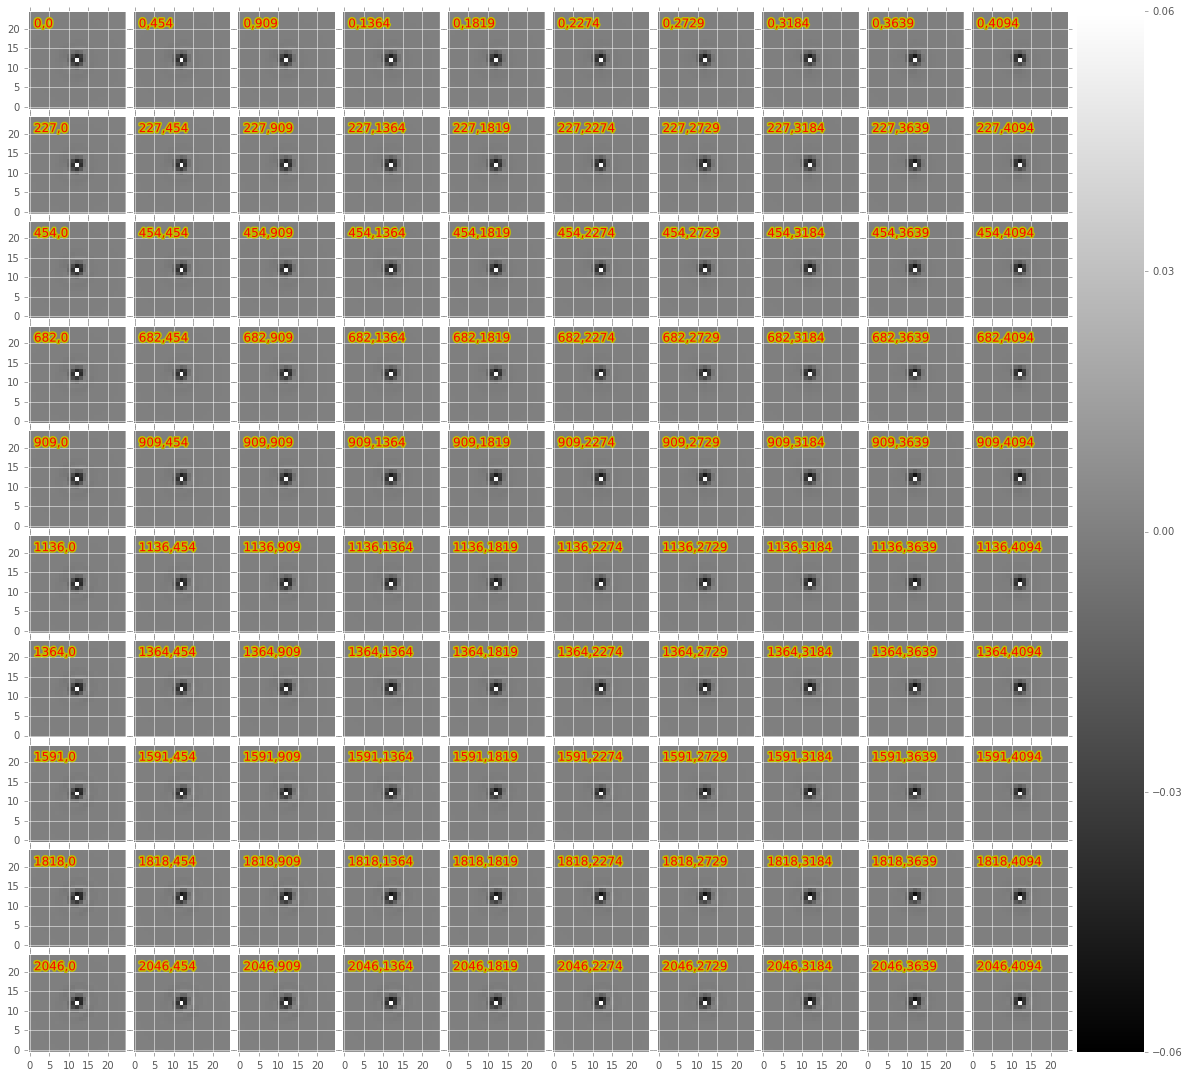

In [11]:
from lsst.ip.diffim import DecorrelateALKernelTask
import lsst.ip.diffim as ipDiffim
print ipDiffim.__path__

_, _, var1 = dit.computeClippedAfwStats(sciImg.getMaskedImage().getVariance(),
                                maskIm=sciImg.getMaskedImage().getMask())  # mean, std, var
_, _, var2 = dit.computeClippedAfwStats(templImg.getMaskedImage().getVariance(),
                                maskIm=templImg.getMaskedImage().getMask())

kimages2 = [DecorrelateALKernelTask._fixOddKernel(kimg) for kimg in kimages]

corrKernels = [DecorrelateALKernelTask._computeDecorrelationKernel(kimg, svar=var1, tvar=var2) \
               for kimg in kimages]
corrKernels = [DecorrelateALKernelTask._fixEvenKernel(kimg) for kimg in corrKernels]
#print [np.max(k) for k in corrKernels]

titles = ['%d,%d' % (x,y) for \
          x in np.linspace(bbox.getBeginX(), bbox.getEndX(), 10.) for \
          y in np.linspace(bbox.getBeginY(), bbox.getEndY(), 10.)]
dit.plotImageGrid(corrKernels, imScale=2., clim=(-0.06, 0.06), titles=titles)

In [12]:
%timeit DecorrelateALKernelTask._computeDecorrelationKernel(kimages[0], svar=var1, tvar=var2)

1000 loops, best of 3: 371 µs per loop


Find the matching kernels that are the most different, then compare them and their resulting decor. kernels...

0.0861250926096 990 [9, 90]


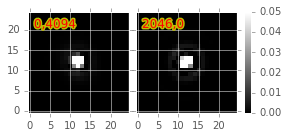

In [13]:
diffs = [np.sqrt(np.sum((k1 - k2)**2.)) for k1 in kimages for k2 in kimages]
coords = [[i, j] for i in range(len(kimages)) for j in range(len(kimages))]
print np.max(diffs), np.argmax(diffs), coords[np.argmax(diffs)]
coo = coords[np.argmax(diffs)]
dit.plotImageGrid([kimages[coo[0]], kimages[coo[1]]], imScale=2., clim=(0., 0.05), 
                  titles=[titles[coo[0]], titles[coo[1]]])

1.34368498459 1.33742425907
1.34368498459 1.33742425907


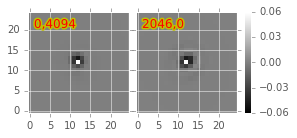

In [14]:
print corrKernels[coo[0]].max(), corrKernels[coo[1]].max()
dit.plotImageGrid([corrKernels[coo[0]], corrKernels[coo[1]]], imScale=2., clim=(-0.06, 0.06), 
                  titles=[titles[coo[0]], titles[coo[1]]])
print np.max([kc.max() for kc in corrKernels]), np.min([kc.max() for kc in corrKernels])

Got the centering correct!

Now let's see if using the two different kernels affects the statistics of the decorr-ed diffim.

I re-wrote the `DecorrelateALKernelTask.run()` method to take an `xcen` and `ycen` parameter so we can set the central coordinate to use for computing `kappa` (default is the center of the image). It can also take an input `var1` and `var2`.

Try again, using updated `DecorrelateALKernelTask.run()` that can take input variances and coordinate to use to compute the matching kernel to use to compute the decorrelation kernel.

In [195]:
# Reload all of the images in case they were screwed up above
im1 = afwImage.ExposureF('diffexp-11.fits')   # uncorrected diffim
im2 = afwImage.ExposureF('decamDirTest/deepDiff/v289820/diffexp-11.fits')  # decorrelated diffim

# Also load the original science and template images
sciImg = afwImage.ExposureF('calexpDir_b1631/0289820/calexp/calexp-0289820_11.fits')
templImg = afwImage.ExposureF('calexpDir_b1631/0288976/calexp/calexp-0288976_11.fits')

In [196]:
from lsst.ip.diffim import DecorrelateALKernelTask
task = DecorrelateALKernelTask()

OK, it seems to work. Slight differences are likely due to the fact that we use the warped template in the actual pipeline; here we are using the original (unwarped) template (actually, is that true?)...

In [197]:
def doDecorr(sciImg, templImg, im1, spatialKernel, xcen=None, ycen=None, svar=None, tvar=None):
    sci = sciImg.clone()
    templ = templImg.clone()
    diffim = im1.clone()
    task = DecorrelateALKernelTask()
    return task.run(sci, templ, diffim, spatialKernel, xcen=xcen, ycen=ycen, svar=svar, tvar=tvar)

In [198]:
decorrResult = doDecorr(sciImg, templImg, im1, spatialKernel)
print dit.computeClippedAfwStats(im2.getMaskedImage())
print dit.computeClippedAfwStats(decorrResult.correctedExposure.getMaskedImage())

print dit.computeClippedAfwStats(im2.getMaskedImage().getVariance(), 
                                 maskIm=im2.getMaskedImage().getMask())
print dit.computeClippedAfwStats(decorrResult.correctedExposure.getMaskedImage().getVariance(),
                                maskIm=decorrResult.correctedExposure.getMaskedImage().getMask())

(-0.46355821737899067, 11.472812119874122, 131.62541793793054)
(-0.46432963102702596, 11.470459128026862, 131.57143260773478)
(120.79661344366045, 4.509143439935214, 20.332374561910775)
(120.78832678513814, 4.505324124626674, 20.29794546794311)


OK, we'll compute decorr-ed diffim's for variances at both ends of the tails in the histogram above, and for matching kernels covering the two extremes plotted above.

In [201]:
decorrResults = [doDecorr(sciImg, templImg, im1, spatialKernel, xcen=xy[0], ycen=xy[1], svar=v2, tvar=v1) for \
                 xy in [(1023,2047), (0,4094), (2046,0), (None, None)] for v1 in (60., 58., 62., None) for v2 in (62.7, 61.5, 64.5, None)]

In [202]:
print len(decorrResults)
print [(xy[0], xy[1], v2, v1) for \
                 xy in [(1023,2047), (0,4094), (2046,0), (None, None)] for v1 in (60., 58., 62., None) for v2 in (62.7, 61.5, 64.5, None)]

64
[(1023, 2047, 62.7, 60.0), (1023, 2047, 61.5, 60.0), (1023, 2047, 64.5, 60.0), (1023, 2047, None, 60.0), (1023, 2047, 62.7, 58.0), (1023, 2047, 61.5, 58.0), (1023, 2047, 64.5, 58.0), (1023, 2047, None, 58.0), (1023, 2047, 62.7, 62.0), (1023, 2047, 61.5, 62.0), (1023, 2047, 64.5, 62.0), (1023, 2047, None, 62.0), (1023, 2047, 62.7, None), (1023, 2047, 61.5, None), (1023, 2047, 64.5, None), (1023, 2047, None, None), (0, 4094, 62.7, 60.0), (0, 4094, 61.5, 60.0), (0, 4094, 64.5, 60.0), (0, 4094, None, 60.0), (0, 4094, 62.7, 58.0), (0, 4094, 61.5, 58.0), (0, 4094, 64.5, 58.0), (0, 4094, None, 58.0), (0, 4094, 62.7, 62.0), (0, 4094, 61.5, 62.0), (0, 4094, 64.5, 62.0), (0, 4094, None, 62.0), (0, 4094, 62.7, None), (0, 4094, 61.5, None), (0, 4094, 64.5, None), (0, 4094, None, None), (2046, 0, 62.7, 60.0), (2046, 0, 61.5, 60.0), (2046, 0, 64.5, 60.0), (2046, 0, None, 60.0), (2046, 0, 62.7, 58.0), (2046, 0, 61.5, 58.0), (2046, 0, 64.5, 58.0), (2046, 0, None, 58.0), (2046, 0, 62.7, 62.0), (2046

In [203]:
reload(dit)
decorrStats = [dit.computeClippedAfwStats(res.correctedExposure.getMaskedImage().getVariance(),
                                maskIm=res.correctedExposure.getMaskedImage().getMask()) for res in decorrResults]

64 [ 120.85704091  121.86376964  119.41464739  120.79302685  119.13384183
  120.10946687  117.73606802  119.07179871  122.57597912  123.61366185
  121.08914583  122.50999315  120.8523394   121.85895959  119.41006118
  120.78832679  121.25760948  122.27055188  119.80617339  121.19321692
  119.52358964  120.50535892  118.11686562  119.46116706  122.98709042
  124.03105417  121.49116549  122.92072404  121.25286867  122.26571904
  119.80156692  121.18847279  120.2383715   121.23372337  118.81232333
  120.17506571  118.53470407  119.49924313  117.15285625  118.47336688
  121.93793253  122.96399496  120.46785313  121.87268272  120.23371472
  121.22898196  118.80778387  120.17043169  120.85704091  121.86376964
  119.41464739  120.79302685  119.13384183  120.10946687  117.73606802
  119.07179871  122.57597912  123.61366185  121.08914583  122.50999315
  120.8523394   121.85895959  119.41006118  120.78832679]
0.056997464185 0.0127308267049


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1294bec10>]], dtype=object)

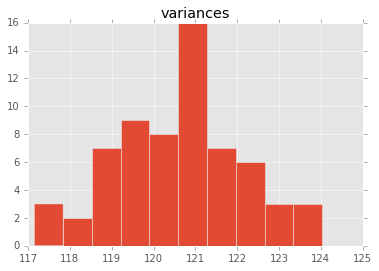

In [204]:
decorrVars = np.array([dc[0] for dc in decorrStats])
print len(decorrVars), decorrVars
print (decorrVars.max()-decorrVars.min())/decorrVars.mean(), decorrVars.std()/decorrVars.mean()
import pandas as pd
pd.DataFrame({'variances': decorrVars}).hist(bins=10)

64 [ 20.32064695  20.65492275  19.8462038   20.29949969  19.75440516
  20.07415128  19.3007877   19.73415567  20.89293741  21.24214961
  20.39751119  20.87082051  20.31909154  20.65331881  19.84467653
  20.29794547  20.46912698  20.80716788  19.98914121  20.44771493
  19.89634499  20.21966878  19.43736145  19.87586817  21.04784093
  21.40097995  20.54684698  21.02550703  20.46754873  20.80554787
  19.98762651  20.44613789  20.09250916  20.42029282  19.62727313
  20.07173689  19.53731347  19.85078105  19.09233689  19.51745248
  20.6537598   20.99618654  20.16783678  20.6320701   20.09098075
  20.41875234  19.6257997   20.07021687  20.32064695  20.65492275
  19.8462038   20.29949969  19.75440516  20.07415128  19.3007877
  19.73415567  20.89293741  21.24214961  20.39751119  20.87082051
  20.31909154  20.65331881  19.84467653  20.29794547]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x20d1dbcd0>]], dtype=object)

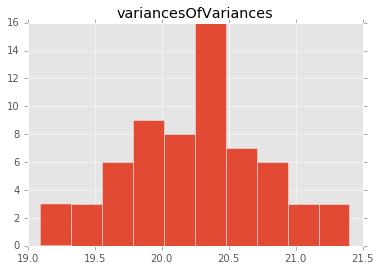

In [205]:
decorrVarVars = np.array([dc[2] for dc in decorrStats])
print len(decorrVarVars), decorrVarVars
pd.DataFrame({'variancesOfVariances': decorrVarVars}).hist(bins=10)

In [206]:
tmp = {str(i): res.correctedExposure.getMaskedImage().getVariance().getArray()[res.correctedExposure.getMaskedImage().getMask().getArray() == 0]
                                for i, res in enumerate(decorrResults)}
print len(tmp), type(tmp['0'])
for k, t in tmp.items():
    t[t > 200] = np.nan

64 <type 'numpy.ndarray'>


(100, 150)

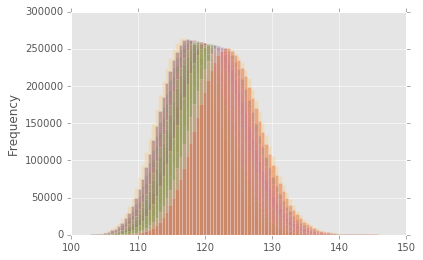

In [207]:
df = pd.DataFrame(tmp)
df.plot.hist(bins=200, alpha=0.3, legend=False)
plt.xlim(100, 150)

So it looks like the variance (note this is the *mean variance of the entire image*) could be off by up to nearly 6% if we use the wrong combination of kernel and variances in the decorrelation. This will affect the detection rate, but should not affect the photometry.

Is this small enough to not worry about it? Will it be bigger for LSST single-CCD exposures?

The variances *of the variances* is of the order 22.0, so this variation of about 7.0 is about 1/3-sigma.

In [208]:
del tmp  # free up memory
del df

Look at the pixel covariances of these different diffim realizations:

In [209]:
tmp = [computePixelCovariances(res.correctedExposure) for res in decorrResults]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15c112710>]], dtype=object)

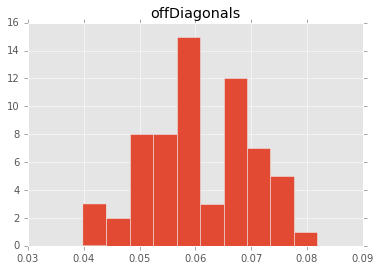

In [210]:
offDiags = [t[1] for t in tmp]
pd.DataFrame({'offDiagonals': offDiags}).hist(bins=10)

Recall the off diagonal covariances were 0.348901792193 and 0.0600425152596 for uncorrected and "canonical" corrected diffims.

64


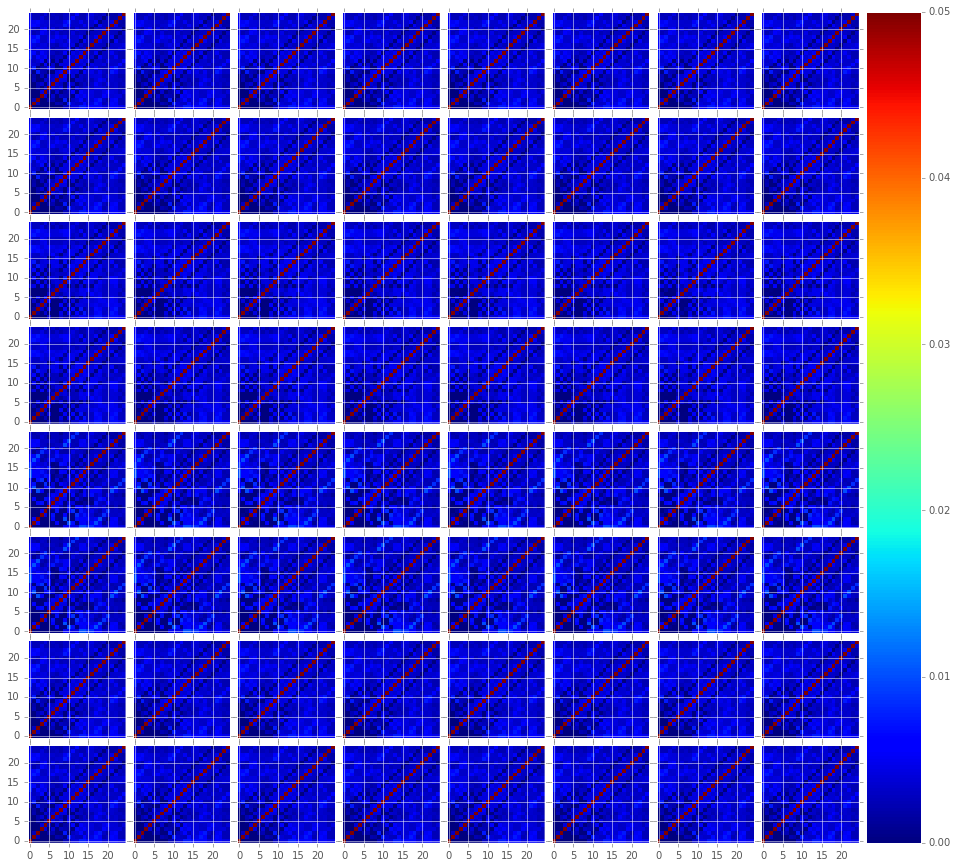

In [211]:
covs = [t[0] for t in tmp]
#covs.append(cov2)  # original corrected diffim
#covs.append(cov1)  # uncorrected diffim
print len(covs)
dit.plotImageGrid(covs, imScale=2., clim=(0, 0.05), nrows_ncols=(8, 8), cmap=None)

Finally, do detection on the different diffims, to see how many pos/neg detections there are.

In [212]:
import lsst.meas.algorithms as measAlg
import lsst.afw.table as afwTable

def doDetection(exposure, detectSigma=5.0, grow=2, verbose=False):
    #mask = exposure.getMaskedImage().getMask()
    #mask &= ~(mask.getPlaneBitMask('DETECTED') | mask.getPlaneBitMask('DETECTED_NEGATIVE'))
    #psf = exposure.getPsf()
    #ctr = afwGeom.Box2D(exposure.getBBox()).getCenter()
    #psfAttr = measAlg.PsfAttributes(psf, afwGeom.Point2I(ctr))
    #psfSigma = psfAttr.computeGaussianWidth(psfAttr.ADAPTIVE_MOMENT)
    #psfWidth = psf.computeShape().getDeterminantRadius()
    #print psfSigma, psfWidth
    
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = 'both'
    config.reEstimateBackground = False
    #config.nSigmaToGrow = psfWidth
    config.thresholdValue = detectSigma
    config.thresholdType = 'pixel_stdev'  # why are we using this instead of 'variance'?
    schema = afwTable.SourceTable.makeMinimalSchema()  
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.run(table, exposure, doSmooth=True, clearMask=True) #, sigma=psfWidth)
    
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, grow, grow, False) 
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    if verbose:
        print 'POSITIVE SOURCES:', results.fpSets.numPos
        print 'NEGATIVE SOURCES:', results.fpSets.numNeg
        print 'MERGED SOURCES:', len(sources)
    return sources

s = doDetection(im1, verbose=True)
s = doDetection(im2, verbose=True)
print;
s = doDetection(decorrResult.correctedExposure, verbose=True)
print len(s)
s = doDetection(decorrResults[63].correctedExposure, verbose=True)  # last one should equal the 'original' decorr-ed one

POSITIVE SOURCES: 89
NEGATIVE SOURCES: 328
MERGED SOURCES: 395
POSITIVE SOURCES: 43
NEGATIVE SOURCES: 18
MERGED SOURCES: 50

POSITIVE SOURCES: 43
NEGATIVE SOURCES: 18
MERGED SOURCES: 50
50
POSITIVE SOURCES: 25
NEGATIVE SOURCES: 7
MERGED SOURCES: 29


In [213]:
print im2.getPsf().computeShape().getDeterminantRadius()
print decorrResult.correctedExposure.getPsf().computeShape().getDeterminantRadius()
print decorrResults[63].correctedExposure.getPsf().computeShape().getDeterminantRadius()

print dit.computeClippedAfwStats(im2.getMaskedImage())
print dit.computeClippedAfwStats(decorrResult.correctedExposure.getMaskedImage())
print dit.computeClippedAfwStats(decorrResults[63].correctedExposure.getMaskedImage())

2.15338379076
2.15338379076
2.15338379076
(-0.46355821737899067, 11.472812119874122, 131.62541793793054)
(-0.46355821737899067, 11.472812119874122, 131.62541793793054)
(-0.46319402414338134, 11.47304196948869, 131.63069203364893)


In [214]:
sources = [doDetection(res.correctedExposure) for res in decorrResults]
print [len(s) for s in sources]

[29, 29, 29, 29, 30, 29, 30, 30, 28, 28, 29, 28, 29, 29, 29, 29, 29, 29, 30, 29, 30, 29, 30, 30, 29, 28, 29, 29, 29, 29, 30, 29, 28, 28, 29, 28, 30, 29, 30, 30, 28, 27, 28, 28, 28, 28, 29, 28, 29, 29, 29, 29, 30, 29, 30, 30, 28, 28, 29, 28, 29, 29, 29, 29]
